# Variational Autoencoder using a Contrastive Loss to create Embeddings of tabular data

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import scripts.dataloader

### Hyperparameters

In [5]:
# TODO add to config
input_dim = 120 # TODO calculate from dataloader
hidden_dim = 164
latent_dim = 64
batch_size = 128
epochs = 1000
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

verbose = True

### Variational Autoencoder

In [6]:
# encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, latent_dim)
        self.fc32 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return torch.sigmoid(self.fc3(h))


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim).to(device)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim).to(device)

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return self.reparameterize(mu, logvar)

    def decode(self, z):
        return self.decoder(z)

### Loss for contrastive learning

In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        """
        Triplet loss function for contrastive learning
        :param margin: margin between positive and negative sample
        """
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, a, p, n):
        """
        Calculates the triplet loss for a batch of anchor, positive and negative samples.
        Tip: hard examples (i.e. positive and negative samples are close), speed up training
        Loss cannot be below 0 and is only positive if distance between anchor and positive sample is larger than
        distance between anchor and negative sample plus margin.
        :param a: anchor samples
        :param p: positive samples
        :param n: negative samples
        :return: triplet loss
        """
        distance_positive = torch.norm(a - p, dim=1)
        distance_negative = torch.norm(a - n, dim=1)
        loss_triplet = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0)
        return loss_triplet

In [8]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        """
        Contrastive loss function for contrastive learning
        :param margin: margin between positive and negative sample
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, label):
        """
        Calculates the contrastive loss for a batch of samples.
        :param z1: samples 1
        :param z2: samples 2
        :param label: label 1 if samples are similar, 0 if samples are different
        :return: contrastive loss
        """
        distance = torch.norm(z1 - z2, dim=1)
        loss_contrastive = torch.mean((1 - label) * torch.pow(distance, 2) + label * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss_contrastive

In [9]:
class CustomLoss(nn.Module):
    def __init__(self):
        """
        Custom loss function for variational autoencoder
        """
        super(CustomLoss, self).__init__()

    # TODO split loss_catgorical into loss per one-hot encoded feature (due to codependecy of features)
    def forward(self, input, target, mu, logvar, cols):
        """
        Calculates the custom loss for a batch of samples. Loss for the reconstruction of numerical features is calculated using
        cosine embedding loss. Loss for the reconstruction of categorical features is calculated using binary cross entropy loss.
        :param input: reconstructed samples
        :param target: original samples
        :param mu: mean of latent space
        :param logvar: log variance of latent space
        :param cosine_label: label 1 if samples are similar, -1 if samples are different
        :return: custom loss
        """

        # numerical features cosine similarity loss
        loss_numerical = 1 - F.cosine_similarity(input[:, :4], target[:, :4], dim=1)

        # one-hot-encoded features binary cross entropy loss
        loss_categorical = 0.
        for start, end in get_one_hot_index(cols):
            start += 4
            end += 4
            loss_numerical += F.binary_cross_entropy(input[:, start:end], target[:, start:end])

        # kullback-leibler divergence loss
        loss_kdl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_numerical + loss_categorical + loss_kdl

In [10]:
def get_one_hot_index(cols):
    """
    Generates a list of indexes (start, end) for one hot encoded columns based on prefix of column names
    :param cols: list of column names
    :return: list of (start, end) tuples
    """
    one_hot_index = []
    start = 0
    end = 0
    current = cols[0].split('_')[0]
    for i in cols:
        if i.split('_')[0] == current:
            end += 1
        else:
            one_hot_index.append((start, end))
            start = end
            end += 1
            current = i.split('_')[0]

    return one_hot_index

### Testing model

In [36]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, verbose):

    col_names = train_loader.dataset.data.columns
    model.train()

    best_current_loss = None

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs, mu, logvar = model(inputs)

            l1 = labels[::2]
            l2 = labels[1::2]
            labels_contrastive = (l2 == l1).float()


            # Encode inputs and compute cosine embedding loss
            z = model.encode(inputs)
            z1 = z[::2]
            z2 = z[1::2]

            loss_contrastive = ContrastiveLoss(20)(z1, z2, labels_contrastive)
            loss_bce = criterion(outputs, inputs, mu, logvar, col_names)

            loss = loss_contrastive + loss_bce

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if verbose:
            if epoch % 2 == 0:
                print("Epoch {} loss: {:.4f}".format(epoch + 1, running_loss / len(dataloader)))
                print("Contrastive loss: {:.4f}".format(loss_contrastive))
                print("BCE loss: {:.4f}".format(loss_bce))

        if epoch % 100 == 0:
            if best_current_loss > running_loss / len(dataloader):
                best_current_loss = running_loss / len(dataloader)
                torch.save(model.state_dict(), '../../models/checkpoints/best_model.pt')
                print('Model saved')

In [ ]:
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = CustomLoss().to(device)

In [50]:

dataset = scripts.dataloader.TabularDataset(label_col='family')
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:

train_model(model, train_loader, criterion, optimizer, epochs, verbose)

In [2]:
def train_triplet_model(model, dataloader, criterion, optimizer, num_epochs, verbose):

    col_names = train_loader.dataset.data.columns
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (anchor, positive, negative, labels) in enumerate(dataloader):
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()

            #stack anchor, positive and negative samples
            inputs = torch.cat((anchor, positive, negative), 0)

            outputs, mu, logvar = model(inputs)

            # Encode inputs and compute cosine embedding loss
            a = model.encode(anchor)
            p = model.encode(positive)
            n = model.encode(negative)

            loss_contrastive = torch.sum(TripletLoss(20)(a, p, n)) * 3
            #loss_bce = torch.sum(criterion(outputs, inputs, mu, logvar, col_names))

            loss = loss_contrastive
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if verbose:
            if epoch % 2 == 0:
                print("Epoch {} loss: {:.4f}".format(epoch + 1, running_loss / len(dataloader)))
                print("Contrastive loss: {:.4f}".format(loss_contrastive))
                #print("BCE loss: {:.4f}".format(loss_bce))

In [ ]:
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = CustomLoss().to(device)

dataset = scripts.dataloader.TripletDataset(label_col='family')
train_loader_triplet = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_triplet_model(model, train_loader_triplet, criterion, optimizer, epochs, verbose)

In [51]:
def get_embeddings(vae_model, dataset):
    """
    returns embeddings for all data points in dataset
    :param vae_model: trained VAE model
    :param dataset: dataset to get embeddings for
    :return: embeddings
    """
    vae_model.eval()
    embeddings = []
    for i, (inputs, labels) in enumerate(dataset):
        inputs = inputs.to(device)
        embeddings.append(vae_model.encode(inputs).detach().cpu().numpy())
    return np.concatenate(embeddings)

def get_labels(dataset):
    """
    returns labels for all data points in dataset
    :param dataset: dataset to get labels for
    :return: labels
    """
    labels = []
    for i, (inputs, label) in enumerate(dataset):
        labels.append(label.detach().cpu().numpy())
    return np.concatenate(labels)

def decode_embeddings(vae_model, embeddings):
    """
    returns decoded embeddings
    :param vae_model: trained VAE model
    :param embeddings: embeddings to decode
    :return: decoded embeddings
    """
    vae_model.eval()
    embeddings = torch.from_numpy(embeddings).to(device)
    return vae_model.decode(embeddings).detach().cpu().numpy()

def get_data(vae_model, dataset):
    """
    returns data points for all data points in dataset
    :param vae_model: trained VAE model
    :param dataset: dataset to get data points for
    :return: data points
    """
    vae_model.eval()
    data = []
    for i, (inputs, labels) in enumerate(dataset):
        inputs = inputs.to(device)
        data.append(inputs.detach().cpu().numpy())
    return np.concatenate(data)

In [52]:
embeddings = get_embeddings(model, train_loader)

In [53]:
decoded_embeddings = decode_embeddings(model, embeddings)

In [54]:
# calculate reconstruction error
reconstruction_error = np.mean(np.power(get_data(model, train_loader) - decoded_embeddings, 2), axis=1)

### Visualizing embeddings

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [57]:
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=500)
tsne_results = tsne.fit_transform(embeddings)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 4352 samples in 0.000s...
[t-SNE] Computed neighbors for 4352 samples in 0.350s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4352
[t-SNE] Computed conditional probabilities for sample 2000 / 4352
[t-SNE] Computed conditional probabilities for sample 3000 / 4352
[t-SNE] Computed conditional probabilities for sample 4000 / 4352
[t-SNE] Computed conditional probabilities for sample 4352 / 4352
[t-SNE] Mean sigma: 2.215019
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.884293
[t-SNE] KL divergence after 500 iterations: 3.825022


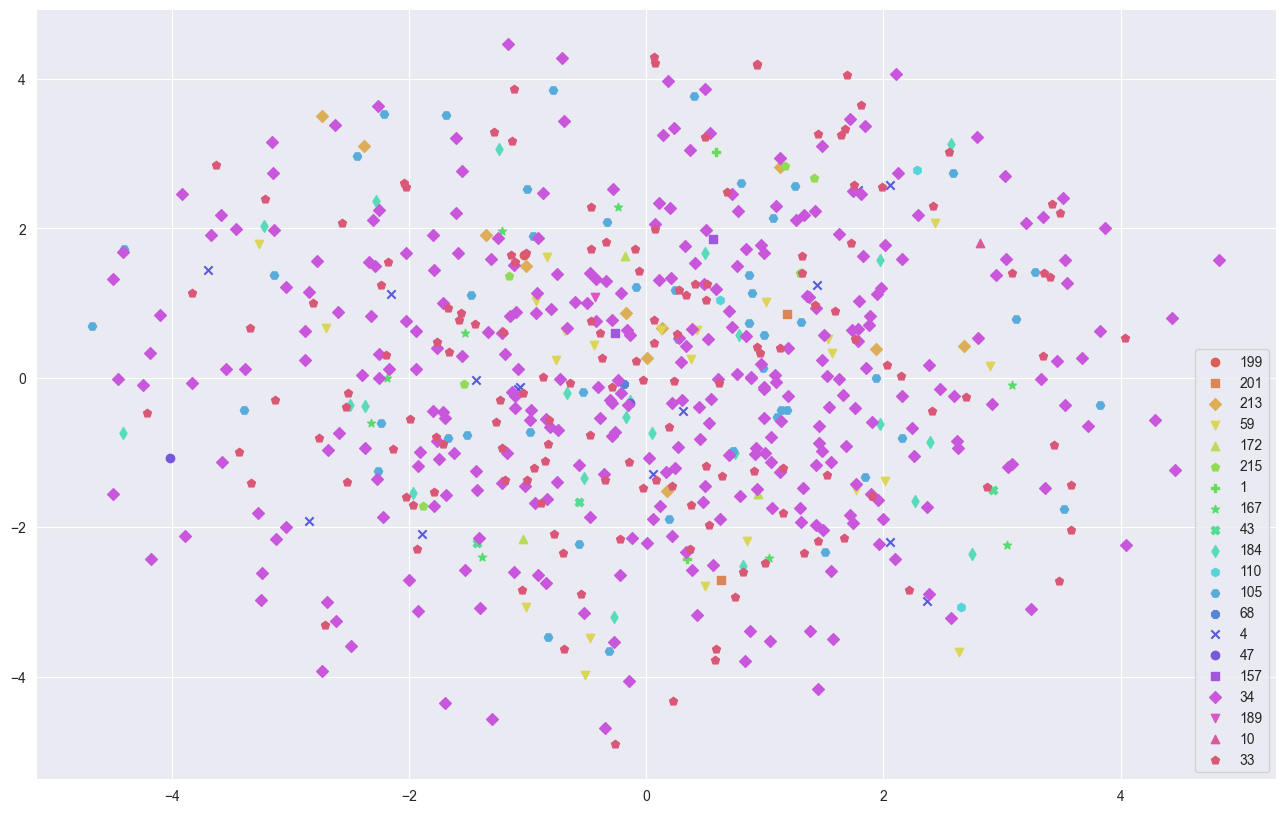

In [58]:
df_subset = pd.DataFrame()
df_subset['x-tsne'] = tsne_results[:,0]
df_subset['y-tsne'] = tsne_results[:,1]
df_subset['label'] = get_labels(train_loader)

# plot 20 random classes
classes = np.random.choice(df_subset['label'].unique(), 20)

colors = sns.color_palette("hls", len(classes))
# shapes
shapes = ['o', 's', 'D', 'v', '^', 'p', 'P', '*', 'X', 'd', 'h', 'H', '8', 'x', 'o', 's', 'D', 'v', '^', 'p']

plt.figure(figsize=(16,10))
for i, c in enumerate(classes):
    subset = df_subset[df_subset['label'] == c]
    plt.scatter(subset['x-tsne'], subset['y-tsne'], label=c, color=colors[i], marker=shapes[i])


plt.legend()
plt.show()

In [59]:
colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6727999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.33999999999999997, 0.36079999999999973, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7767999999999993),
 (0.86, 0.33999999999999997, 0.6207999999999999),
 (0.86, 0.33999999999999997, 0.46479999999999977)]

#### UMap

In [60]:
import umap

In [61]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(embeddings)
embedding.shape

(4352, 2)

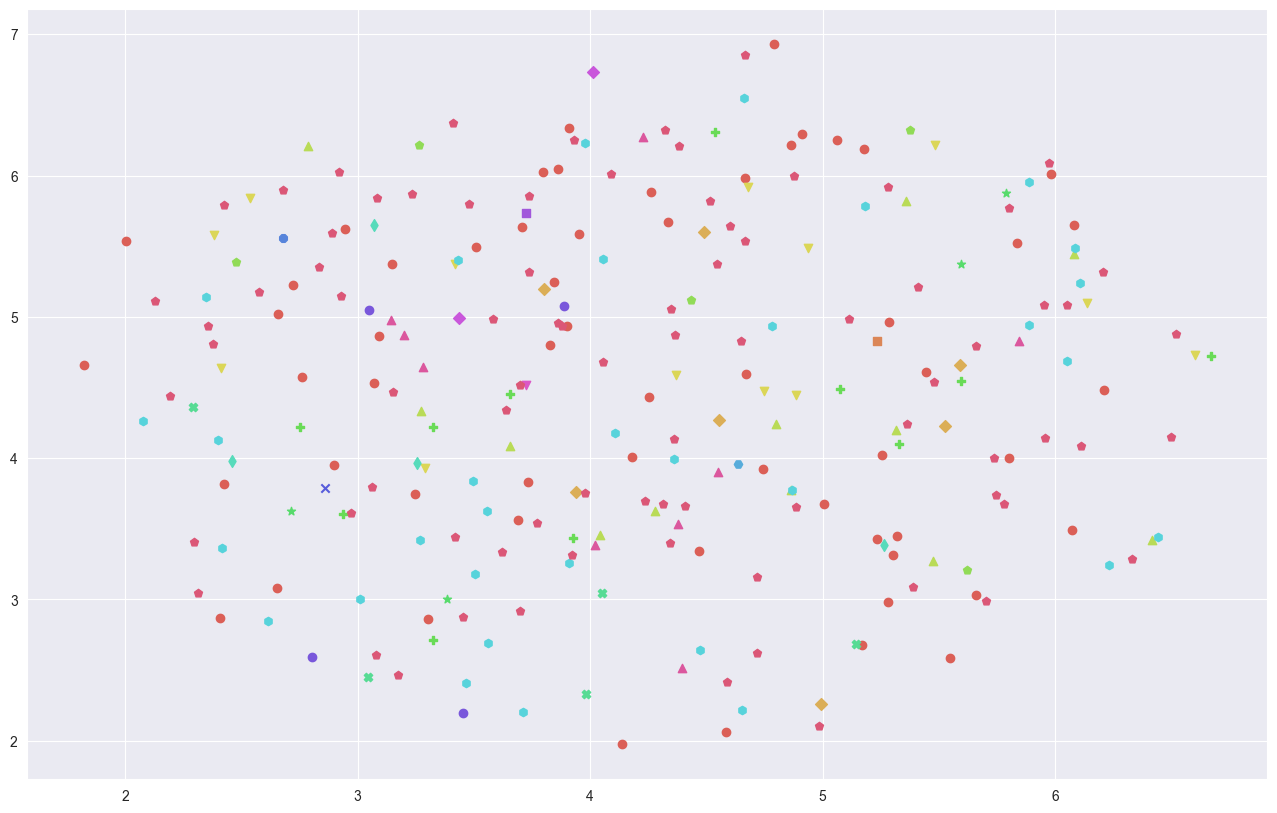

In [62]:
df_subset = pd.DataFrame()
df_subset['x-tsne'] = embedding[:,0]
df_subset['y-tsne'] = embedding[:,1]
df_subset['label'] = get_labels(train_loader)

classes = np.random.choice(df_subset['label'].unique(), 20)

colors = sns.color_palette("hls", len(classes))

plt.figure(figsize=(16,10))
for i, c in enumerate(classes):
    subset = df_subset[df_subset['label'] == c]
    plt.scatter(subset['x-tsne'], subset['y-tsne'], label=c, color=colors[i], marker=shapes[i])

plt.show()